# Prepare Order Flow Data for Power BI

This notebook extracts and transforms real market data from DuckDB into Order Flow format for Power BI visualization.

**What it does:**
- Reads real orderbook data from `metrics_1s` table
- Generates Order Flow aggregates for multiple time windows (1s, 3s, 1m, 5m)
- Calculates bid/ask volumes at different price levels
- Exports to CSV for Power BI Python visuals

**Prerequisites:** 
- DuckDB warehouse must be set up (run `2_duckdb_warehouse_setup.ipynb` first)

## Setup Environment

In [1]:
# Environment setup
import os
import sys
from pathlib import Path

REPO_DIR = '/content/drive/My Drive/00_EUREX/eurex-liquidity-demo'
assert os.path.exists(REPO_DIR), f'Repo not found: {REPO_DIR}'

DB_PATH = f"{REPO_DIR}/warehouse/eurex.duckdb"
EXPORT_DIR = f"{REPO_DIR}/dashboards/order_flow_chart/powerbi"

# Create export directory
os.makedirs(EXPORT_DIR, exist_ok=True)

print("Environment configured")
print(f"   Repo: {REPO_DIR}")
print(f"   DB:   {DB_PATH}")
print(f"   Export: {EXPORT_DIR}")

Environment configured
   Repo: /content/drive/My Drive/00_EUREX/eurex-liquidity-demo
   DB:   /content/drive/My Drive/00_EUREX/eurex-liquidity-demo/warehouse/eurex.duckdb
   Export: /content/drive/My Drive/00_EUREX/eurex-liquidity-demo/dashboards/order_flow_chart/powerbi


In [2]:
# Import libraries
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

print("✅ Libraries imported")

✅ Libraries imported


## Connect to DuckDB

In [3]:
# Connect to database
con = duckdb.connect(DB_PATH, read_only=True)

# Check available data
row_count = con.execute("SELECT COUNT(*) FROM metrics_1s").fetchone()[0]
segments = con.execute("SELECT DISTINCT segment_id FROM metrics_1s ORDER BY segment_id").df()['segment_id'].tolist()

print(f"✅ Connected to {DB_PATH}")
print(f"   Total 1s intervals: {row_count:,}")
print(f"   Available segments: {segments}")

✅ Connected to /content/drive/My Drive/00_EUREX/eurex-liquidity-demo/warehouse/eurex.duckdb
   Total 1s intervals: 1,252,799
   Available segments: [48, 589, 688, 702, 821, 1209]


## Explore Data Structure

In [4]:
# Check data structure
sample = con.execute("""
    SELECT 
        segment_id,
        security_id,
        ts_s,
        best_bid,
        best_ask,
        bid_size_1,
        ask_size_1,
        total_bid_volume,
        total_ask_volume,
        midprice,
        spread_abs,
        imbalance_l1
    FROM metrics_1s 
    WHERE segment_id = 589  -- Most active segment
    ORDER BY ts_s
    LIMIT 10
""").df()

print("📊 Sample data from segment 589:")
print("="*70)
display(sample)

print("\nColumns available for Order Flow:")
for col in sample.columns:
    print(f"  - {col}")

📊 Sample data from segment 589:


,segment_id,security_id,ts_s,best_bid,best_ask,bid_size_1,ask_size_1,total_bid_volume,total_ask_volume,midprice,spread_abs,imbalance_l1
0,589,72060123773665340,1606781706,1.5,16.5,5.0,6.0,137.0,72.0,9.00,15.0,-0.090909
1,589,72060123773665341,1606781706,-9.5,20.0,20.0,18.0,26.0,27.0,5.25,29.5,0.052632
2,589,72060123773665342,1606781706,-17.0,10.0,1.0,20.0,2.0,23.0,-3.50,27.0,-0.904762
3,589,5035771,1606781706,13406.0,13407.5,1.0,1.0,10.0,10.0,13406.75,1.5,0.000000
4,589,5336359,1606781706,13339.0,13394.5,1.0,1.0,19.0,5.0,13366.75,55.5,0.000000
5,589,5594748,1606781706,13343.5,13401.0,1.0,1.0,3.0,3.0,13372.25,57.5,0.000000
6,589,5035771,1606781707,13404.5,13353.5,1.0,1.0,10.0,9.0,13379.00,-51.0,0.000000
7,589,5336359,1606781707,13395.0,13344.5,1.0,1.0,19.0,5.0,13369.75,-50.5,0.000000
8,589,5594748,1606781707,13399.5,13351.0,1.0,1.0,3.0,3.0,13375.25,-48.5,0.000000
9,589,5035771,1606781708,13391.5,13399.5,7.0,1.0,26.0,17.0,13395.50,8.0,0.750000



Columns available for Order Flow:
  - segment_id
  - security_id
  - ts_s
  - best_bid
  - best_ask
  - bid_size_1
  - ask_size_1
  - total_bid_volume
  - total_ask_volume
  - midprice
  - spread_abs
  - imbalance_l1


## Function: Generate Order Flow Data

In [5]:
def generate_order_flow_data(con, segment_id, time_window_seconds, price_tick=0.5, max_rows=10000):
    """
    Generate Order Flow data from real market data.
    
    Parameters:
    - con: DuckDB connection
    - segment_id: Segment to analyze
    - time_window_seconds: Time aggregation window (1, 3, 60, 300)
    - price_tick: Price level granularity (default 0.5)
    - max_rows: Maximum rows to return
    
    Returns:
    - DataFrame with columns: time_bin, price_level, bid_volume, ask_volume, net_volume, trade_count
    """
    
    query = f"""
    WITH base_data AS (
        SELECT 
            -- Time bucketing
            CAST(ts_s / {time_window_seconds} AS INTEGER) * {time_window_seconds} as time_bin,
            
            -- Price level bucketing (round to nearest tick)
            ROUND(best_bid / {price_tick}) * {price_tick} as bid_price_level,
            ROUND(best_ask / {price_tick}) * {price_tick} as ask_price_level,
            ROUND(midprice / {price_tick}) * {price_tick} as mid_price_level,
            
            -- Volumes
            COALESCE(total_bid_volume, 0) as bid_vol,
            COALESCE(total_ask_volume, 0) as ask_vol,
            
            -- Additional metrics
            update_count
        FROM metrics_1s
        WHERE segment_id = {segment_id}
          AND best_bid IS NOT NULL 
          AND best_ask IS NOT NULL
          AND total_bid_volume IS NOT NULL
          AND total_ask_volume IS NOT NULL
    ),
    
    -- Aggregate by time bin and price level
    aggregated AS (
        SELECT 
            time_bin,
            mid_price_level as price_level,
            SUM(bid_vol) as bid_volume,
            SUM(ask_vol) as ask_volume,
            SUM(bid_vol) - SUM(ask_vol) as net_volume,
            COUNT(*) as trade_count,
            AVG(bid_price_level) as avg_bid_price,
            AVG(ask_price_level) as avg_ask_price
        FROM base_data
        GROUP BY time_bin, mid_price_level
    )
    
    SELECT 
        time_bin,
        price_level,
        CAST(bid_volume AS INTEGER) as bid_volume,
        CAST(ask_volume AS INTEGER) as ask_volume,
        CAST(net_volume AS INTEGER) as net_volume,
        CAST(trade_count AS INTEGER) as trade_count,
        ROUND(avg_bid_price, 4) as avg_bid_price,
        ROUND(avg_ask_price, 4) as avg_ask_price
    FROM aggregated
    ORDER BY time_bin, price_level DESC
    LIMIT {max_rows}
    """
    
    df = con.execute(query).df()
    return df

print("✅ Function defined: generate_order_flow_data()")

✅ Function defined: generate_order_flow_data()


## Generate Order Flow Data for Multiple Time Windows

In [6]:
# Configuration
TIME_WINDOWS = {
    '1s': 1,
    '3s': 3,
    '1m': 60,
    '5m': 300
}

# Get all available segments
TARGET_SEGMENTS = segments  # Use all segments from the database

print(f"🎯 Generating Order Flow data for ALL Segments: {TARGET_SEGMENTS}")
print("="*70)

all_order_flow_data = []

for segment_id in TARGET_SEGMENTS:
    print(f"\n{'='*70}")
    print(f"📊 Processing Segment {segment_id}")
    print(f"{'='*70}")
    
    for window_name, window_seconds in TIME_WINDOWS.items():
        print(f"\n   ⏱️  {window_name} ({window_seconds}s windows)...")
        
        try:
            df = generate_order_flow_data(
                con=con,
                segment_id=segment_id,
                time_window_seconds=window_seconds,
                price_tick=0.5,
                max_rows=20000  # Limit for performance
            )
            
            if len(df) == 0:
                print(f"      ⚠️  No data for segment {segment_id} - {window_name}")
                continue
            
            # Add metadata columns
            df['time_window'] = window_name
            df['segment_id'] = segment_id
            
            # ✨ Add trading time column (from time_bin)
            df['trading_time'] = pd.to_datetime(df['time_bin'], unit='s')
            
            all_order_flow_data.append(df)
            
            print(f"      ✅ {len(df):,} rows")
            print(f"      📅 Time: {df['trading_time'].min()} to {df['trading_time'].max()}")
            print(f"      💰 Price: {df['price_level'].min():.2f} to {df['price_level'].max():.2f}")
            print(f"      📈 Bid: {df['bid_volume'].sum():,} | Ask: {df['ask_volume'].sum():,} | Net: {df['net_volume'].sum():+,}")
            
        except Exception as e:
            print(f"      ❌ Error processing segment {segment_id} - {window_name}: {e}")
            continue

print("\n" + "="*70)
print(f"✅ Order Flow data generation complete!")
print(f"   Total segments processed: {len(TARGET_SEGMENTS)}")
print(f"   Total dataframes generated: {len(all_order_flow_data)}")

# Combine all data
if all_order_flow_data:
    combined_all_df = pd.concat(all_order_flow_data, ignore_index=True)
    print(f"   Total rows: {len(combined_all_df):,}")
    print(f"   Segments: {sorted(combined_all_df['segment_id'].unique())}")
    print(f"   Time windows: {sorted(combined_all_df['time_window'].unique())}")
else:
    print("   ⚠️  No data generated!")
    combined_all_df = pd.DataFrame()

🎯 Generating Order Flow data for ALL Segments: [48, 589, 688, 702, 821, 1209]

📊 Processing Segment 48

   ⏱️  1s (1s windows)...


      ✅ 2,725 rows
      📅 Time: 2020-12-01 08:01:37 to 2020-12-01 16:30:00
      💰 Price: 269.00 to 273.50
      📈 Bid: 40,865 | Ask: 40,865 | Net: +0

   ⏱️  3s (3s windows)...
      ✅ 2,214 rows
      📅 Time: 2020-12-01 08:01:36 to 2020-12-01 16:30:00
      💰 Price: 269.00 to 273.50
      📈 Bid: 40,865 | Ask: 40,865 | Net: +0

   ⏱️  1m (60s windows)...
      ✅ 640 rows
      📅 Time: 2020-12-01 08:02:00 to 2020-12-01 16:30:00
      💰 Price: 269.00 to 273.50
      📈 Bid: 40,865 | Ask: 40,865 | Net: +0

   ⏱️  5m (300s windows)...
      ✅ 210 rows
      📅 Time: 2020-12-01 08:00:00 to 2020-12-01 16:30:00
      💰 Price: 269.00 to 273.50
      📈 Bid: 40,865 | Ask: 40,865 | Net: +0

📊 Processing Segment 589

   ⏱️  1s (1s windows)...
      ✅ 20,000 rows
      📅 Time: 2020-12-01 00:15:06 to 2020-12-01 05:14:27
      💰 Price: -3.50 to 13589.50
      📈 Bid: 245,536 | Ask: 188,017 | Net: +57,519

   ⏱️  3s (3s windows)...
      ✅ 20,000 rows
      📅 Time: 2020-12-01 00:15:06 to 2020-12-01 05:

## Preview Data

In [7]:
# Preview data
if len(combined_all_df) > 0:
    print("📊 Sample: Order Flow Data (All Segments)")
    print("="*70)
    display(combined_all_df.head(20))
    
    print("\n📊 Data Statistics by Segment and Time Window:")
    print("="*70)
    
    stats = combined_all_df.groupby(['segment_id', 'time_window']).agg({
        'time_bin': 'count',
        'price_level': 'nunique',
        'bid_volume': 'sum',
        'ask_volume': 'sum',
        'net_volume': 'sum',
        'trading_time': ['min', 'max']
    }).round(0)
    
    stats.columns = ['Rows', 'Unique_Prices', 'Total_Bid', 'Total_Ask', 'Net_Volume', 'Time_Start', 'Time_End']
    display(stats)
    
    print("\n📊 Summary by Segment:")
    print("="*70)
    segment_summary = combined_all_df.groupby('segment_id').agg({
        'time_bin': 'count',
        'bid_volume': 'sum',
        'ask_volume': 'sum',
        'net_volume': 'sum'
    })
    segment_summary.columns = ['Total_Rows', 'Total_Bid_Vol', 'Total_Ask_Vol', 'Net_Volume']
    display(segment_summary)
    
    print("\n📊 Column Info:")
    print("="*70)
    print(f"Columns: {list(combined_all_df.columns)}")
    print(f"\nData types:")
    display(combined_all_df.dtypes)
else:
    print("⚠️  No data to preview")

📊 Sample: Order Flow Data (All Segments)


,time_bin,price_level,bid_volume,ask_volume,net_volume,trade_count,avg_bid_price,avg_ask_price,time_window,segment_id,trading_time
0,1606809697,270.5,15,15,0,1,270.0,271.0,1s,48,2020-12-01 08:01:37
1,1606809701,270.0,15,15,0,1,269.5,270.5,1s,48,2020-12-01 08:01:41
2,1606809778,270.5,15,15,0,1,270.0,271.0,1s,48,2020-12-01 08:02:58
3,1606809810,270.0,15,15,0,1,269.5,270.5,1s,48,2020-12-01 08:03:30
4,1606809816,270.5,15,15,0,1,270.0,271.0,1s,48,2020-12-01 08:03:36
5,1606809824,269.5,15,15,0,1,269.0,270.0,1s,48,2020-12-01 08:03:44
6,1606809832,269.0,15,15,0,1,269.0,269.5,1s,48,2020-12-01 08:03:52
7,1606809886,270.5,15,15,0,1,270.5,271.0,1s,48,2020-12-01 08:04:46
8,1606809902,269.5,15,15,0,1,269.0,270.0,1s,48,2020-12-01 08:05:02
9,1606809913,270.5,15,15,0,1,270.0,271.0,1s,48,2020-12-01 08:05:13



📊 Data Statistics by Segment and Time Window:


Rows  Unique_Prices   Total_Bid   Total_Ask  \
segment_id time_window                                                 
48         1m             640             10       40865       40865   
           1s            2725             10       40865       40865   
           3s            2214             10       40865       40865   
           5m             210             10       40865       40865   
589        1m           20000            234      587547      456040   
           1s           20000            215      245536      188017   
           3s           20000            215      266768      204944   
           5m           16357            238     1527856     1283720   
688        1m            9635             19  1869096825  2070570298   
           1s           20000             17    88933502   109102731   
           3s           20000             17   193628824   232897812   
           5m            2254             19  1869096825  2070570298   
702        1m             166              1      339529      341853   
           1s             333              1      339529      341853   
           3s             279              1      339529      341853   
           5m              79              1      339529      341853   
821        1m            7063             33    33182059    33497292   
           1s           20000             30     9606542     9646066   
           3s           20000             30    15004617    15320377   
           5m            2065             33    33182059    33497292   

                        Net_Volume          Time_Start            Time_End  
segment_id time_window                                                      
48         1m                    0 2020-12-01 08:02:00 2020-12-01 16:30:00  
           1s                    0 2020-12-01 08:01:37 2020-12-01 16:30:00  
           3s                    0 2020-12-01 08:01:36 2020-12-01 16:30:00  
           5m                    0 2020-12-01 08:00:00 2020-12-01 16:30:00  
589        1m               131507 2020-12-01 00:15:00 2020-12-01 09:38:00  
           1s                57519 2020-12-01 00:15:06 2020-12-01 05:14:27  
           3s                61824 2020-12-01 00:15:06 2020-12-01 05:40:03  
           5m               244136 2020-12-01 00:15:00 2020-12-01 21:00:00  
688        1m           -201473473 2020-12-01 00:15:00 2020-12-01 21:00:00  
           1s            -20169229 2020-12-01 00:15:09 2020-12-01 07:58:42  
           3s            -39268988 2020-12-01 00:15:09 2020-12-01 08:46:51  
           5m           -201473473 2020-12-01 00:15:00 2020-12-01 21:00:00  
702        1m                -2324 2020-12-01 07:02:00 2020-12-01 17:58:00  
           1s                -2324 2020-12-01 07:02:00 2020-12-01 17:58:09  
           3s                -2324 2020-12-01 07:02:00 2020-12-01 17:58:09  
           5m                -2324 2020-12-01 07:00:00 2020-12-01 18:00:00  
821        1m              -315233 2020-12-01 07:04:00 2020-12-01 21:00:00  
           1s               -39524 2020-12-01 07:04:27 2020-12-01 09:59:38  
           3s              -315760 2020-12-01 07:04:27 2020-12-01 12:15:03  
           5m              -315233 2020-12-01 07:05:00 2020-12-01 21:00:00


📊 Summary by Segment:


,Total_Rows,Total_Bid_Vol,Total_Ask_Vol,Net_Volume
segment_id,,,,
48,5789,163460,163460,0
589,76357,2627707,2132721,494986
688,51889,4020755976,4483141139,-462385163
702,857,1358116,1367412,-9296
821,49128,90975277,91961027,-985750



📊 Column Info:
Columns: ['time_bin', 'price_level', 'bid_volume', 'ask_volume', 'net_volume', 'trade_count', 'avg_bid_price', 'avg_ask_price', 'time_window', 'segment_id', 'trading_time']

Data types:


,0
time_bin,int32
price_level,float64
bid_volume,int32
ask_volume,int32
net_volume,int32
trade_count,int32
avg_bid_price,float64
avg_ask_price,float64
time_window,object
segment_id,int64


## Visualize Order Flow (Sample)

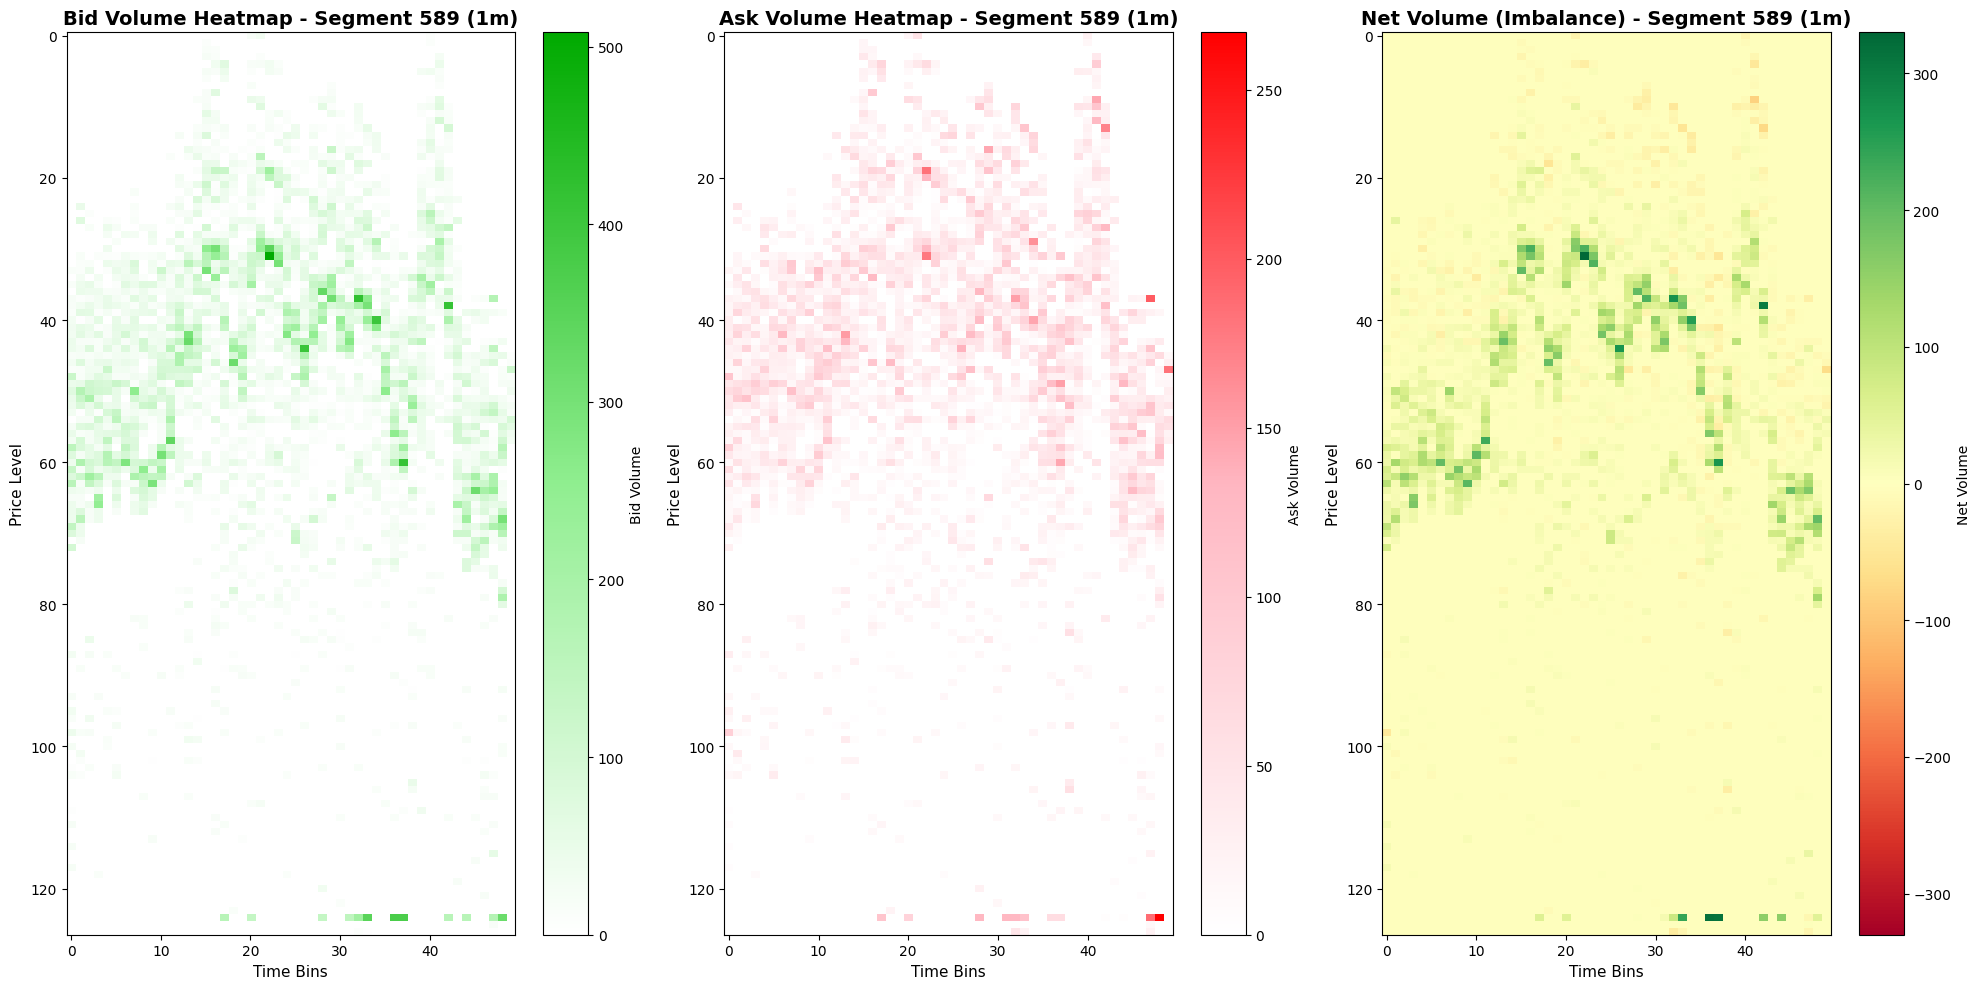


✅ Preview saved to: /content/drive/My Drive/00_EUREX/eurex-liquidity-demo/dashboards/order_flow_chart/powerbi/order_flow_preview.png


In [8]:
# Visualize a sample (segment 589, 1m window) as heatmap
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

if len(combined_all_df) > 0:
    # Select 1m data from segment 589 (most active)
    df_vis = combined_all_df[(combined_all_df['segment_id'] == 589) & 
                             (combined_all_df['time_window'] == '1m')].copy()
    
    if len(df_vis) > 0:
        # Get last 50 time bins
        recent_times = sorted(df_vis['time_bin'].unique())[-50:]
        df_vis = df_vis[df_vis['time_bin'].isin(recent_times)]
        
        # Create pivot tables
        pivot_bid = df_vis.pivot_table(
            values='bid_volume',
            index='price_level',
            columns='time_bin',
            fill_value=0
        ).sort_index(ascending=False)
        
        pivot_ask = df_vis.pivot_table(
            values='ask_volume',
            index='price_level',
            columns='time_bin',
            fill_value=0
        ).sort_index(ascending=False)
        
        pivot_net = df_vis.pivot_table(
            values='net_volume',
            index='price_level',
            columns='time_bin',
            fill_value=0
        ).sort_index(ascending=False)
        
        # Create figure
        fig, axes = plt.subplots(1, 3, figsize=(20, 10))
        
        # Color maps
        cmap_green = LinearSegmentedColormap.from_list('bid', ['white', '#90EE90', '#00AA00'])
        cmap_red = LinearSegmentedColormap.from_list('ask', ['white', '#FFB6C1', '#FF0000'])
        
        # Plot 1: Bid Volume
        im1 = axes[0].imshow(pivot_bid.values, aspect='auto', cmap=cmap_green, interpolation='nearest')
        axes[0].set_title('Bid Volume Heatmap - Segment 589 (1m)', fontsize=14, fontweight='bold')
        axes[0].set_ylabel('Price Level', fontsize=11)
        axes[0].set_xlabel('Time Bins', fontsize=11)
        plt.colorbar(im1, ax=axes[0], label='Bid Volume')
        
        # Plot 2: Ask Volume
        im2 = axes[1].imshow(pivot_ask.values, aspect='auto', cmap=cmap_red, interpolation='nearest')
        axes[1].set_title('Ask Volume Heatmap - Segment 589 (1m)', fontsize=14, fontweight='bold')
        axes[1].set_ylabel('Price Level', fontsize=11)
        axes[1].set_xlabel('Time Bins', fontsize=11)
        plt.colorbar(im2, ax=axes[1], label='Ask Volume')
        
        # Plot 3: Net Volume
        vmax = abs(pivot_net.values).max()
        im3 = axes[2].imshow(pivot_net.values, aspect='auto', cmap='RdYlGn', 
                             interpolation='nearest', vmin=-vmax, vmax=vmax)
        axes[2].set_title('Net Volume (Imbalance) - Segment 589 (1m)', fontsize=14, fontweight='bold')
        axes[2].set_ylabel('Price Level', fontsize=11)
        axes[2].set_xlabel('Time Bins', fontsize=11)
        plt.colorbar(im3, ax=axes[2], label='Net Volume')
        
        plt.tight_layout()
        plt.savefig(f"{EXPORT_DIR}/order_flow_preview.png", dpi=150, bbox_inches='tight')
        plt.show()
        
        print(f"\n✅ Preview saved to: {EXPORT_DIR}/order_flow_preview.png")
    else:
        print("⚠️  No data available for segment 589 - 1m window")
else:
    print("⚠️  No data to visualize")

## Export to CSV for Power BI

In [9]:
# Export Order Flow data to CSV
print("📤 Exporting Order Flow data to CSV...")
print("="*70)

if len(combined_all_df) > 0:
    # 1. Export main combined file (ALL segments, ALL windows)
    combined_filepath = os.path.join(EXPORT_DIR, "order_flow_data.csv")
    combined_all_df.to_csv(combined_filepath, index=False)
    combined_size = os.path.getsize(combined_filepath) / 1024 / 1024
    
    print(f"\n✅ Main File (use this in Power BI):")
    print(f"   📊 order_flow_data.csv")
    print(f"      - {len(combined_all_df):>8,} rows")
    print(f"      - {combined_size:>7.2f} MB")
    print(f"      - Segments: {sorted(combined_all_df['segment_id'].unique())}")
    print(f"      - Time windows: {sorted(combined_all_df['time_window'].unique())}")
    
    # 2. Optional: Export by time window (for convenience)
    print(f"\n📁 Optional files by time window:")
    for window in sorted(combined_all_df['time_window'].unique()):
        df_window = combined_all_df[combined_all_df['time_window'] == window]
        filename = f"order_flow_{window}.csv"
        filepath = os.path.join(EXPORT_DIR, filename)
        df_window.to_csv(filepath, index=False)
        file_size = os.path.getsize(filepath) / 1024 / 1024
        num_segments = df_window['segment_id'].nunique()
        print(f"   ✅ {filename:<25s} ({len(df_window):>8,} rows, {file_size:>7.2f} MB, {num_segments} segments)")
    
    print("\n" + "="*70)
    print(f"✅ Files exported to: {EXPORT_DIR}/")
    
    print("\n📋 CSV Columns:")
    for col in combined_all_df.columns:
        dtype = combined_all_df[col].dtype
        example = combined_all_df[col].iloc[0]
        print(f"   • {col:<20s} ({dtype}) - Example: {example}")
    
    print("\n" + "="*70)
    print("🎯 Power BI Setup Guide:")
    print("\n1️⃣  Load Data:")
    print("   • Get Data → CSV → order_flow_data.csv")
    
    print("\n2️⃣  Add Slicers (Filters):")
    print("   • segment_id slicer → Choose which segment to analyze")
    print("   • time_window slicer → Choose 1s / 3s / 1m / 5m")
    
    print("\n3️⃣  Create Python Visual:")
    print("   • Drag fields to Values area:")
    print("     - time_bin")
    print("     - price_level")
    print("     - bid_volume")
    print("     - ask_volume")
    print("     - net_volume")
    print("     - trading_time")
    print("     - time_window")
    print("     - segment_id")
    
    print("\n4️⃣  Use Python Script:")
    print("   • Copy your Python visualization script")
    print("   • The slicer selections will automatically filter the dataset")
    
    print("\n" + "="*70)
    
else:
    print("⚠️  No data to export")

📤 Exporting Order Flow data to CSV...

✅ Main File (use this in Power BI):
   📊 order_flow_data.csv
      -  184,020 rows
      -   12.62 MB
      - Segments: [np.int64(48), np.int64(589), np.int64(688), np.int64(702), np.int64(821)]
      - Time windows: ['1m', '1s', '3s', '5m']

📁 Optional files by time window:
   ✅ order_flow_1m.csv         (  37,504 rows,    2.66 MB, 5 segments)
   ✅ order_flow_1s.csv         (  63,058 rows,    4.21 MB, 5 segments)
   ✅ order_flow_3s.csv         (  62,493 rows,    4.22 MB, 5 segments)
   ✅ order_flow_5m.csv         (  20,965 rows,    1.53 MB, 5 segments)

✅ Files exported to: /content/drive/My Drive/00_EUREX/eurex-liquidity-demo/dashboards/order_flow_chart/powerbi/

📋 CSV Columns:
   • time_bin             (int32) - Example: 1606809697
   • price_level          (float64) - Example: 270.5
   • bid_volume           (int32) - Example: 15
   • ask_volume           (int32) - Example: 15
   • net_volume           (int32) - Example: 0
   • trade_count    

In [10]:
# Generate summary report
if len(combined_all_df) > 0:
    print("📊 ORDER FLOW DATA PREPARATION - SUMMARY REPORT")
    print("="*70)
    print(f"Database: {DB_PATH}")
    print(f"Export Directory: {EXPORT_DIR}")
    print(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print("="*70)
    
    print("\n📈 Data Summary:")
    print(f"   Segments: {sorted(combined_all_df['segment_id'].unique())}")
    print(f"   Time Windows: {sorted(combined_all_df['time_window'].unique())}")
    print(f"   Total Rows: {len(combined_all_df):,}")
    print(f"   Date Range: {combined_all_df['trading_time'].min()} to {combined_all_df['trading_time'].max()}")
    print(f"   Price Range: {combined_all_df['price_level'].min():.2f} to {combined_all_df['price_level'].max():.2f}")
    print(f"   Total Bid Volume: {combined_all_df['bid_volume'].sum():,}")
    print(f"   Total Ask Volume: {combined_all_df['ask_volume'].sum():,}")
    print(f"   Net Volume: {combined_all_df['net_volume'].sum():+,}")
    
    print("\n📊 Breakdown by Segment:")
    segment_stats = combined_all_df.groupby('segment_id').agg({
        'time_bin': 'count',
        'bid_volume': 'sum',
        'ask_volume': 'sum',
        'net_volume': 'sum',
        'trading_time': ['min', 'max']
    })
    segment_stats.columns = ['Rows', 'Bid_Vol', 'Ask_Vol', 'Net_Vol', 'Start_Time', 'End_Time']
    display(segment_stats)
    
    print("\n📊 Breakdown by Time Window:")
    window_stats = combined_all_df.groupby('time_window').agg({
        'time_bin': 'count',
        'segment_id': 'nunique',
        'bid_volume': 'sum',
        'ask_volume': 'sum',
        'net_volume': 'sum'
    })
    window_stats.columns = ['Rows', 'Num_Segments', 'Bid_Vol', 'Ask_Vol', 'Net_Vol']
    display(window_stats)
    
    print("\n📁 Exported Files:")
    csv_files = [f for f in sorted(os.listdir(EXPORT_DIR)) if f.endswith('.csv')]
    total_size = 0
    for file in csv_files:
        filepath = os.path.join(EXPORT_DIR, file)
        size_mb = os.path.getsize(filepath) / 1024 / 1024
        total_size += size_mb
        if file == 'order_flow_data.csv':
            print(f"   ⭐ {file:<30s} {size_mb:>8.2f} MB  ← MAIN FILE (use this)")
        else:
            print(f"   ✅ {file:<30s} {size_mb:>8.2f} MB")
    
    print(f"\n   Total: {len(csv_files)} files, {total_size:.2f} MB")
    
    print("\n✨ Key Features:")
    print("   ✅ All segments in one file (segment_id column)")
    print("   ✅ All time windows in one file (time_window column)")
    print("   ✅ Trading time column (formatted datetime)")
    print("   ✅ Use Power BI slicers to filter segments & windows")
    print("   ✅ Ready for Python visuals")
    
    print("\n💡 Power BI Workflow:")
    print("   1. Load: order_flow_data.csv")
    print("   2. Add slicers: segment_id, time_window")
    print("   3. Create Python visual")
    print("   4. Slicers will auto-filter the data!")
    
    print("\n" + "="*70)
    print("✅ ORDER FLOW DATA READY FOR POWER BI")
    print("="*70)
    
    # Save summary to text file
    summary_file = os.path.join(EXPORT_DIR, "order_flow_summary.txt")
    with open(summary_file, 'w') as f:
        f.write("ORDER FLOW DATA PREPARATION - SUMMARY\n")
        f.write("="*70 + "\n")
        f.write(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        f.write(f"Segments: {sorted(combined_all_df['segment_id'].unique())}\n")
        f.write(f"Time Windows: {sorted(combined_all_df['time_window'].unique())}\n")
        f.write(f"Total Rows: {len(combined_all_df):,}\n")
        f.write(f"Date Range: {combined_all_df['trading_time'].min()} to {combined_all_df['trading_time'].max()}\n\n")
        
        f.write("COLUMNS:\n")
        for col in combined_all_df.columns:
            f.write(f"  - {col}\n")
        
        f.write("\nFILES GENERATED:\n")
        f.write("  ⭐ order_flow_data.csv (MAIN FILE - use this in Power BI)\n")
        for file in csv_files:
            if file != 'order_flow_data.csv':
                f.write(f"  - {file}\n")
        
        f.write("\nKEY FEATURES:\n")
        f.write("  - Single file with all segments (use segment_id to filter)\n")
        f.write("  - Single file with all time windows (use time_window to filter)\n")
        f.write("  - trading_time column: formatted datetime from time_bin\n")
        f.write("  - Power BI slicers handle all filtering\n")
    
    print(f"\n📄 Summary saved to: {summary_file}")
    
    # Close connection
    con.close()
    print("\n✅ Database connection closed")
else:
    print("⚠️  No data to summarize")
    con.close()

📊 ORDER FLOW DATA PREPARATION - SUMMARY REPORT
Database: /content/drive/My Drive/00_EUREX/eurex-liquidity-demo/warehouse/eurex.duckdb
Export Directory: /content/drive/My Drive/00_EUREX/eurex-liquidity-demo/dashboards/order_flow_chart/powerbi
Timestamp: 2025-11-17 18:30:52

📈 Data Summary:
   Segments: [np.int64(48), np.int64(589), np.int64(688), np.int64(702), np.int64(821)]
   Time Windows: ['1m', '1s', '3s', '5m']
   Total Rows: 184,020
   Date Range: 2020-12-01 00:15:00 to 2020-12-01 21:00:00
   Price Range: -6.00 to 13589.50
   Total Bid Volume: 4,115,880,536
   Total Ask Volume: 4,578,765,759
   Net Volume: -462,885,223

📊 Breakdown by Segment:


,Rows,Bid_Vol,Ask_Vol,Net_Vol,Start_Time,End_Time
segment_id,,,,,,
48,5789,163460,163460,0,2020-12-01 08:00:00,2020-12-01 16:30:00
589,76357,2627707,2132721,494986,2020-12-01 00:15:00,2020-12-01 21:00:00
688,51889,4020755976,4483141139,-462385163,2020-12-01 00:15:00,2020-12-01 21:00:00
702,857,1358116,1367412,-9296,2020-12-01 07:00:00,2020-12-01 18:00:00
821,49128,90975277,91961027,-985750,2020-12-01 07:04:00,2020-12-01 21:00:00



📊 Breakdown by Time Window:


,Rows,Num_Segments,Bid_Vol,Ask_Vol,Net_Vol
time_window,,,,,
1m,37504,5,1903246825,2104906348,-201659523
1s,63058,5,99165974,119319532,-20153558
3s,62493,5,209280603,248805851,-39525248
5m,20965,5,1904187134,2105734028,-201546894



📁 Exported Files:
   ✅ order_flow_1m.csv                  2.66 MB
   ✅ order_flow_1s.csv                  4.21 MB
   ✅ order_flow_3s.csv                  4.22 MB
   ✅ order_flow_5m.csv                  1.53 MB
   ⭐ order_flow_data.csv               12.62 MB  ← MAIN FILE (use this)

   Total: 5 files, 25.24 MB

✨ Key Features:
   ✅ All segments in one file (segment_id column)
   ✅ All time windows in one file (time_window column)
   ✅ Trading time column (formatted datetime)
   ✅ Use Power BI slicers to filter segments & windows
   ✅ Ready for Python visuals

💡 Power BI Workflow:
   1. Load: order_flow_data.csv
   2. Add slicers: segment_id, time_window
   3. Create Python visual
   4. Slicers will auto-filter the data!

✅ ORDER FLOW DATA READY FOR POWER BI

📄 Summary saved to: /content/drive/My Drive/00_EUREX/eurex-liquidity-demo/dashboards/order_flow_chart/powerbi/order_flow_summary.txt

✅ Database connection closed
